# Stock Price Prediction using LSTM / Samsung Electronics Co.Ltd

Samsung Electronics Co., Ltd. is a South Korean multinational electronics company headquartered in Suwon, South Korea. It is one of the world's largest producers of electronic devices and is known for its innovative technology and high-quality products. Samsung is a major manufacturer of electronic components such as semiconductors, lithium-ion batteries, and hard drives. It is also a leading brand in consumer electronics, producing smartphones, tablets, televisions, and home appliances.

Below is the Jupyter notebook code to predict the stock price of Samsung Electronics Co., Ltd. using LSTM.

Steps:
1.Load and Inspect Data
2.Preprocess Data
3.Create Training and Testing Sets
4.Build LSTM Model
5.Train the Model
6.Evaluate the Model
7.Make Predictions

An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) designed to effectively capture and model temporal dependencies in sequential data, making it particularly well-suited for time series forecasting. Unlike traditional RNNs, which struggle with long-term dependencies due to the vanishing gradient problem, LSTMs use special units called memory cells that can maintain information over extended periods. These cells have three key gates—input, output, and forget gates—that regulate the flow of information, allowing the model to decide which information to keep, update, or discard. This structure enables LSTMs to learn from both short-term and long-term patterns in the data, making them ideal for applications like stock price prediction, where past prices and trends can significantly influence future values.

In [28]:
import pandas as pd

# Load the data
file_path = 'C:/Users/un/Desktop/005930.KS/005930.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-29,46800.0,47050.0,46000.0,46100.0,40630.378906,6856846
1,2019-07-30,46300.0,46850.0,46300.0,46550.0,41026.988281,5551014
2,2019-07-31,46200.0,46600.0,45000.0,45350.0,39969.359375,12872916
3,2019-08-01,44900.0,45500.0,44850.0,45200.0,39837.167969,7811181
4,2019-08-02,44550.0,45500.0,44300.0,44950.0,39616.816406,12151374


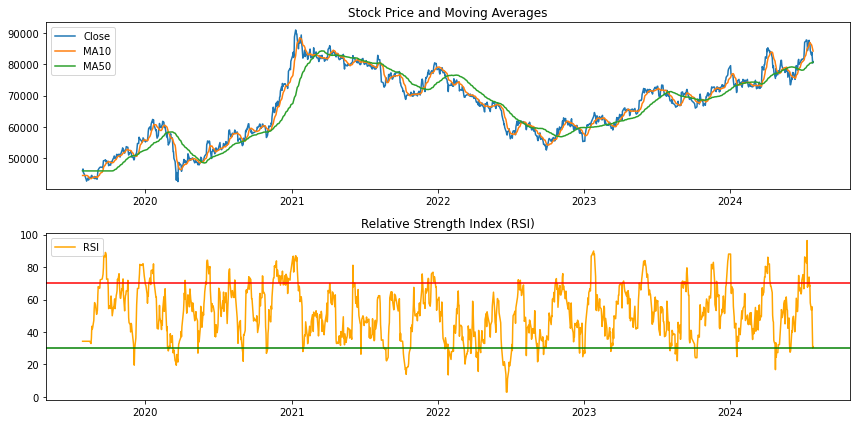

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Fill missing values using forward fill method
data.fillna(method='ffill', inplace=True)

# Add additional features: Moving Averages, Relative Strength Index (RSI)
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Calculate RSI
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Fill missing values in new features using backward fill method
data.fillna(method='bfill', inplace=True)

# Select the Close price and additional features for prediction
features = ['Close', 'MA10', 'MA50', 'RSI']
data = data[features]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a function to prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare the data with a time step of 100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the data to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Plot the processed features
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label='Close')
plt.plot(data.index, data['MA10'], label='MA10')
plt.plot(data.index, data['MA50'], label='MA50')
plt.legend()
plt.title('Stock Price and Moving Averages')

plt.subplot(2, 1, 2)
plt.plot(data.index, data['RSI'], label='RSI', color='orange')
plt.axhline(y=70, color='r', linestyle='-')
plt.axhline(y=30, color='g', linestyle='-')
plt.legend()
plt.title('Relative Strength Index (RSI)')
plt.tight_layout()
plt.show()


X_train shape: (904, 100, 4)
X_test shape: (227, 100, 4)
y_train shape: (904,)
y_test shape: (227,)


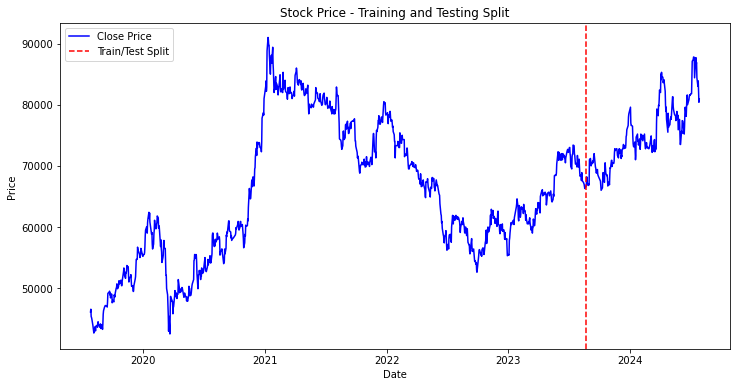

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Select the Close price and additional features for prediction
features = ['Close', 'MA10', 'MA50', 'RSI']
data = data[features]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences for LSTM
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences
time_step = 100
X, y = create_sequences(scaled_data, time_step)

# Split the data into training and testing sets with shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Plot the training and testing data distribution
train_dates = data.index[time_step:len(X_train) + time_step]
test_dates = data.index[len(X_train) + time_step:]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.axvline(x=train_dates[-1], color='r', linestyle='--', label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Stock Price - Training and Testing Split')
plt.show()

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the LSTM model
model = Sequential()

# Add the first LSTM layer with Dropout regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add a second LSTM layer with Dropout regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Add a third LSTM layer with Dropout regularization
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer
model.add(Dense(units=50, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Display the model architecture
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 100)       │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,901 (812.11 KB)

 Trainable params: 207,901 (812.11 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
import datetime

# Define the TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback],
    verbose=1
)

# Load the best model saved during training
model.load_weights('best_model.keras')


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 558ms/step - loss: 0.1007 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - loss: 0.0133 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - loss: 0.0076 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - loss: 0.0063 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - loss: 0.0052 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 446ms/step - loss: 0.0051 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - loss: 0.0045 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - loss: 0.0041 - val_loss: 0.0051 - learning_rate: 2.0000e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - loss: 0.0035 - val_loss: 0.0058 - learning_rate: 2.0

In [16]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [21]:
# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_train_inverse = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]



In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train_inverse, train_predict)
train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predict))
test_mae = mean_absolute_error(y_test_inverse, test_predict)
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predict))

print(f'Training MAE: {train_mae:.4f}')
print(f'Training RMSE: {train_rmse:.4f}')
print(f'Testing MAE: {test_mae:.4f}')
print(f'Testing RMSE: {test_rmse:.4f}')

Training MAE: 2325.6966
Training RMSE: 3207.9584
Testing MAE: 2261.9734
Testing RMSE: 3044.0706


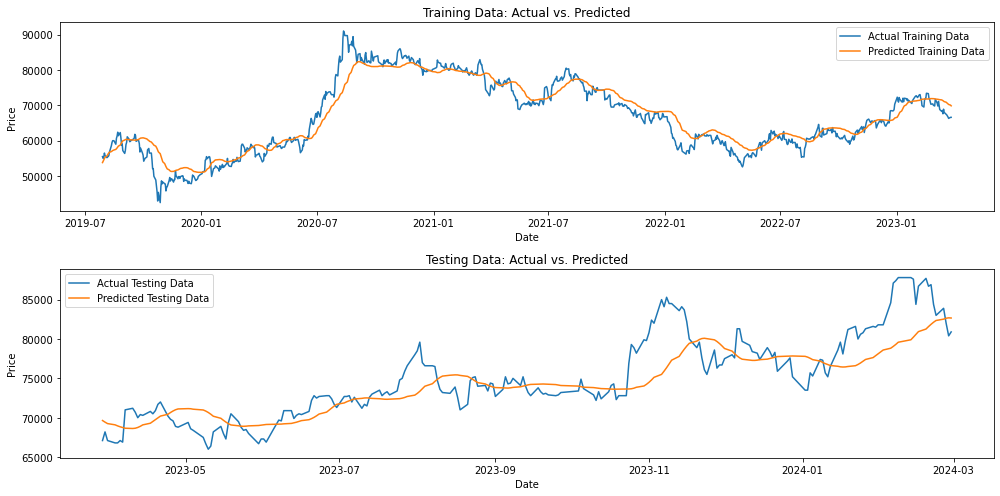

In [23]:
# Plot the predictions versus actual values
plt.figure(figsize=(14, 7))

# Training data predictions
plt.subplot(2, 1, 1)
plt.plot(data.index[:len(y_train_inverse)], y_train_inverse, label='Actual Training Data')
plt.plot(data.index[:len(y_train_inverse)], train_predict, label='Predicted Training Data')
plt.title('Training Data: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Testing data predictions
plt.subplot(2, 1, 2)
plt.plot(data.index[len(y_train_inverse):len(y_train_inverse) + len(y_test_inverse)], y_test_inverse, label='Actual Testing Data')
plt.plot(data.index[len(y_train_inverse):len(y_train_inverse) + len(y_test_inverse)], test_predict, label='Predicted Testing Data')
plt.title('Testing Data: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


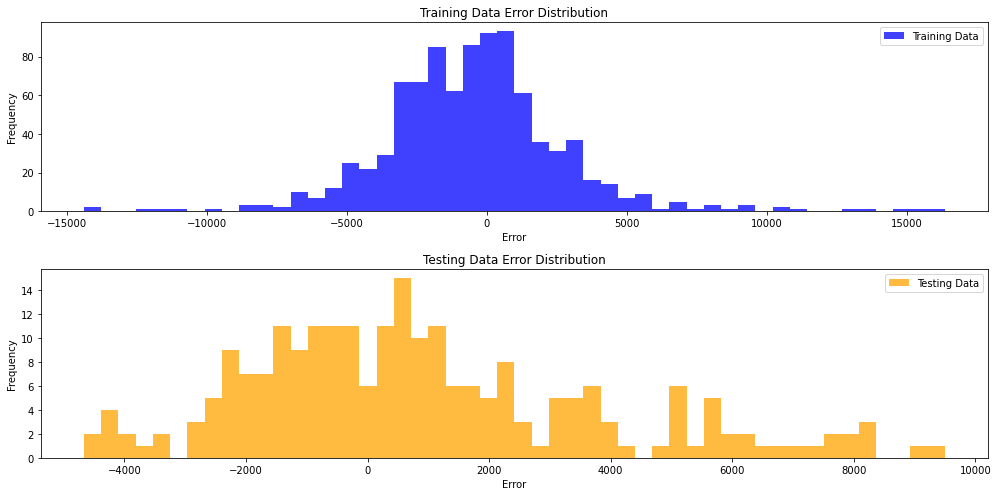

In [25]:
# Calculate errors
train_errors = y_train_inverse - train_predict
test_errors = y_test_inverse - test_predict

# Plot the error distribution
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.hist(train_errors, bins=50, alpha=0.75, color='blue', label='Training Data')
plt.title('Training Data Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(test_errors, bins=50, alpha=0.75, color='orange', label='Testing Data')
plt.title('Testing Data Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



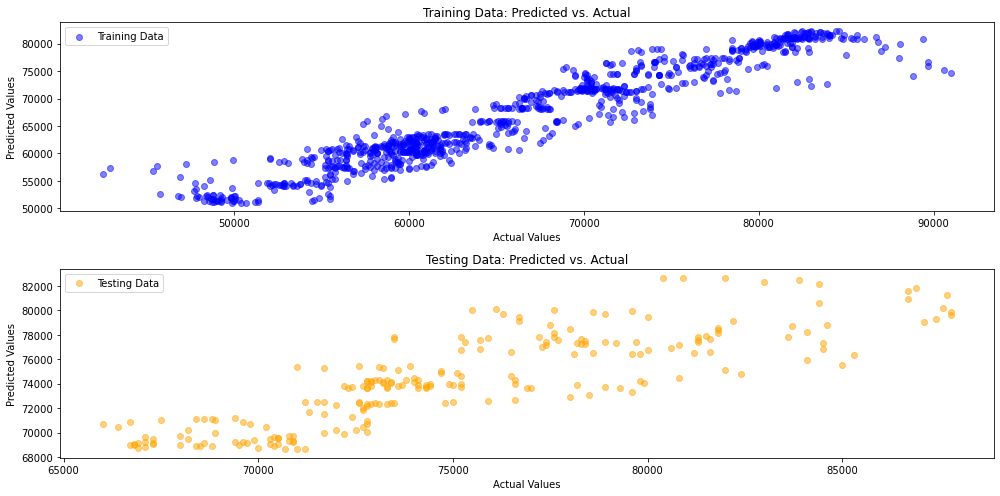

In [26]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.scatter(y_train_inverse, train_predict, alpha=0.5, color='blue', label='Training Data')
plt.title('Training Data: Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(y_test_inverse, test_predict, alpha=0.5, color='orange', label='Testing Data')
plt.title('Testing Data: Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()


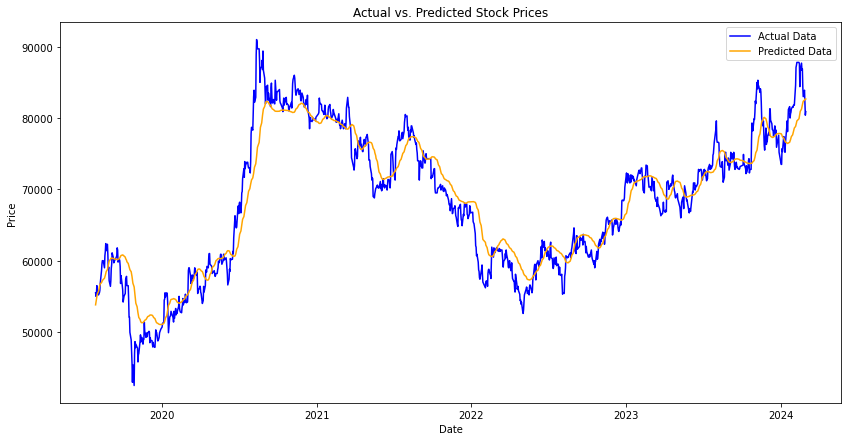

In [27]:
# Combine the predictions with actual values for plotting
full_data_length = len(y_train_inverse) + len(y_test_inverse)
full_actual = np.concatenate([y_train_inverse, y_test_inverse])
full_predictions = np.concatenate([train_predict, test_predict])
full_index = data.index[:full_data_length]

# Time series plot of actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(full_index, full_actual, label='Actual Data', color='blue')
plt.plot(full_index, full_predictions, label='Predicted Data', color='orange')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
